In [25]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import math

import pandas as pd
import numpy as np
import pennylane as qml
from pennylane import numpy as qnp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

For task 3, we need to set the noise config

In [26]:
# -----------------------------
# Task 3 addition: Noise config
# -----------------------------
NOISE_TYPE = "depolarizing"   # Options: "depolarizing" or "amplitude_damping"
NOISE_P = 0.02                # Noise strength (e.g., 0.01..0.05)


First we load the datasets:

In [27]:
gluehwein = 'gluehweindorf'
krampus = 'krampuskogel'
lebkuchen = 'lebkuchenstadt'

villages = [gluehwein, krampus, lebkuchen]
datasets = {}

for village in villages:
        datasets[village] = pd.read_csv(f'{village}.csv')

There are no null values in the dataset and 500 entries

In [28]:
datasets[gluehwein].info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carol_singing    500 non-null    float64
 1   snowball_energy  500 non-null    float64
 2   label            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [29]:
datasets[krampus].info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carol_singing    500 non-null    float64
 1   snowball_energy  500 non-null    float64
 2   label            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [30]:
datasets[lebkuchen].info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carol_singing    500 non-null    float64
 1   snowball_energy  500 non-null    float64
 2   label            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


Min-Max values

In [31]:
for name in (gluehwein, krampus, lebkuchen):
    print(f'{name}-carol_singing: min: {datasets[name]['carol_singing'].min()}, max: {datasets[name]['carol_singing'].max()}')
    print(f'{name}-snowball_energy: min: {datasets[name]['snowball_energy'].min()}, max: {datasets[name]['snowball_energy'].max()}')
    print()

gluehweindorf-carol_singing: min: -2.9804047381428838, max: 2.9371221242497527
gluehweindorf-snowball_energy: min: -2.9723258785728337, max: 3.141592653589793

krampuskogel-carol_singing: min: -3.141592653589793, max: 3.117552213512825
krampuskogel-snowball_energy: min: -2.8957902158960995, max: 2.8898416183940667

lebkuchenstadt-carol_singing: min: -1.620977694446723, max: 3.141592653589793
lebkuchenstadt-snowball_energy: min: -0.6755685974503365, max: 1.4214525718679278



Label values

In [32]:
for name in (gluehwein, krampus, lebkuchen):
    print(f'{name}-labels:  {datasets[gluehwein]['label'].unique()}')


gluehweindorf-labels:  [1 0]
krampuskogel-labels:  [1 0]
lebkuchenstadt-labels:  [1 0]


In [33]:
X_train = {}
y_train = {}

for name in (gluehwein, krampus, lebkuchen):
    X_train[name] = datasets[name][['carol_singing', 'snowball_energy']].values
    y_train[name] = datasets[name]['label'].values

# Encoding

## Amplitude encoding

In [34]:
def amplitude_encoding(inputs, wires):
    qml.AmplitudeEmbedding(
        features=inputs,
        wires=wires,
        normalize=True,
        pad_with=0.0
    )


## Angle encoding

In [35]:
def angle_encoding(inputs, wires):
    qml.AngleEmbedding(
        features=inputs, 
        wires=wires, 
        rotation='Y')

## Density matrix encoding


In [36]:
def density_matrix_encoding(inputs, wires):    
    x0, x1 = inputs
    rho = np.outer(inputs, inputs) / np.inner(inputs, inputs)

    qml.QubitDensityMatrix(rho, wires=wires)

# Entanglement

## Linear Entanglement

In [37]:
def linear_entanglement(wires):
    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

## Circular Entanglement

In [38]:
def circular_entanglement(wires):
    linear_entanglement(wires)
    qml.CNOT(wires=[wires[-1], wires[0]])


## Full Entanglement

In [39]:
def full_entanglement(wires):
    for i in range(len(wires)):
        for j in range(i + 1, len(wires)):
            qml.CNOT(wires=[wires[i], wires[j]])


# QML Circuit

In [40]:
# def make_qml_circuit(dev):
    
#     @qml.qnode(dev)
#     def qml_circuit(weights, inputs, encoding_fn, entanglement_fn, reuploading_count):
#         encoding_fn(inputs, wires=list(range(num_qubits)))

#         for j in range(reuploading_count):
#             entanglement_fn(wires=list(range(num_qubits)))
#             for i in range(num_qubits):
#                 qml.RY(weights[j][i], wires=i)

#         return qml.expval(qml.PauliZ(0)) # this returns a number between the eigenvalues of Z, which are -1 and 1
    
#     return qml_circuit

In [41]:
def make_qml_circuit(dev):
    """
    Task 3 change: add an optional noise toggle (use_noise) while keeping the
    original signature structure as close as possible.
    """

    @qml.qnode(dev)
    def qml_circuit(weights, inputs, encoding_fn, entanglement_fn, reuploading_count, use_noise=False):
        encoding_fn(inputs, wires=list(range(num_qubits)))

        for j in range(reuploading_count):
            entanglement_fn(wires=list(range(num_qubits)))
            for i in range(num_qubits):
                qml.RY(weights[j][i], wires=i)

            # -----------------------------
            # Task 3 addition: Apply noise
            # -----------------------------
            if use_noise:
                if NOISE_TYPE == "depolarizing":
                    for w in range(num_qubits):
                        qml.DepolarizingChannel(NOISE_P, wires=w)
                elif NOISE_TYPE == "amplitude_damping":
                    for w in range(num_qubits):
                        qml.AmplitudeDamping(NOISE_P, wires=w)

        return qml.expval(qml.PauliZ(0))  # returns value in [-1, 1]

    return qml_circuit


# Cost

In [42]:
# def cost(weights, param):
#     [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count] = param
#     predictions = qnp.array([
#         (qml_circuit(weights, x, encoding_fn, entanglement_fn, reuploading_count) * 0.5 + 0.5)
#         for x in X
#     ])
#     eps = 1e-7
    
#     return -qnp.mean(
#         Y * qnp.log(predictions + eps) +
#         (1 - Y) * qnp.log(1 - predictions + eps)
#     )


In [43]:
def cost(weights, param):
    # Task 3 change: param now also includes `use_noise`
    [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise] = param

    predictions = qnp.array([
        (qml_circuit(weights, x, encoding_fn, entanglement_fn, reuploading_count, use_noise=use_noise) * 0.5 + 0.5)
        for x in X
    ])
    eps = 1e-7

    return -qnp.mean(
        Y * qnp.log(predictions + eps) +
        (1 - Y) * qnp.log(1 - predictions + eps)
    )

In [44]:
# def predict_proba(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count):
#     return qnp.array([
#         (qml_circuit(weights, x, encoding_fn, entanglement_fn, reuploading_count) + 1) / 2
#         for x in X
#     ])


# Task 3 change: add optional use_noise parameter
def predict_proba(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise=False):
    return qnp.array([
        (qml_circuit(weights, x, encoding_fn, entanglement_fn, reuploading_count, use_noise=use_noise) + 1) / 2
        for x in X
    ])





# def predict(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count):
#     probs = predict_proba(
#         weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count
#     )
#     return (probs >= 0.5).astype(int)


# Task 3 change: add optional use_noise parameter
def predict(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise=False):
    probs = predict_proba(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise=use_noise)
    return (probs >= 0.5).astype(int)


def accuracy(y_true, y_pred):
    return qnp.mean(y_true == y_pred)


def confusion_matrix(y_true, y_pred):
    tp = qnp.sum((y_true == 1) & (y_pred == 1))
    tn = qnp.sum((y_true == 0) & (y_pred == 0))
    fp = qnp.sum((y_true == 0) & (y_pred == 1))
    fn = qnp.sum((y_true == 1) & (y_pred == 0))

    return qnp.array([[tn, fp],
                      [fn, tp]])


# Evaluation

## Gluehweindorf

In [45]:
# opt = qml.AdamOptimizer(stepsize=0.01)

# num_qubits = 2
# dev = qml.device("default.qubit", wires=num_qubits)

# qml_circuit = make_qml_circuit(dev)

# encoding_fn = amplitude_encoding
# entanglement_fn = linear_entanglement 

# X = X_train[gluehwein]
# Y = y_train[gluehwein]


# for reuploading_count in (1, 3):
#     print(f"\n=== Reuploading count: {reuploading_count} ===")

#     weights = qnp.array(
#         np.random.uniform(0, math.pi, size=(reuploading_count, num_qubits)),
#         requires_grad=True
#     )

#     param = [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count]

#     for epoch in range(100):
#         args, current_cost = opt.step_and_cost(cost, weights, param)
#         weights = args[0]

#         # ---- evaluation (NO gradients needed) ----
#         y_pred = predict(
#             weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count
#         )
#         acc = accuracy(Y, y_pred)

#         if epoch % 10 == 0 or epoch == 99:
#             print(
#                 f"Epoch {epoch + 1:3d} | "
#                 f"Cost = {current_cost:.4f} | "
#                 f"Accuracy = {acc:.3f}"
#             )

#         if epoch == 99:
#             cm = confusion_matrix(Y, y_pred)
#             print("\nConfusion Matrix (rows=true, cols=pred):")
#             print(cm)



=== Gluehweindorf | Reuploading count: 1 ===

--- WITHOUT noise (type=depolarizing, p=0.02) ---
Epoch   1 | Cost = 0.8988 | Accuracy = 0.500 | GradNorm = 0.7133
Epoch  11 | Cost = 0.8351 | Accuracy = 0.500 | GradNorm = 0.5730
Epoch  21 | Cost = 0.7863 | Accuracy = 0.500 | GradNorm = 0.4525
Epoch  31 | Cost = 0.7509 | Accuracy = 0.500 | GradNorm = 0.3501
Epoch  41 | Cost = 0.7268 | Accuracy = 0.500 | GradNorm = 0.2639
Epoch  51 | Cost = 0.7113 | Accuracy = 0.500 | GradNorm = 0.1925
Epoch  61 | Cost = 0.7021 | Accuracy = 0.500 | GradNorm = 0.1347
Epoch  71 | Cost = 0.6971 | Accuracy = 0.500 | GradNorm = 0.0893
Epoch  81 | Cost = 0.6947 | Accuracy = 0.500 | GradNorm = 0.0551
Epoch  91 | Cost = 0.6936 | Accuracy = 0.500 | GradNorm = 0.0308
Epoch 100 | Cost = 0.6933 | Accuracy = 0.500 | GradNorm = 0.0160

Confusion Matrix (rows=true, cols=pred):
[[  0 250]
 [  0 250]]


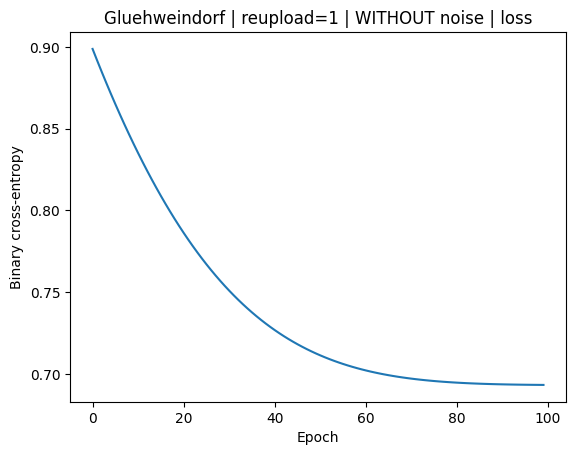

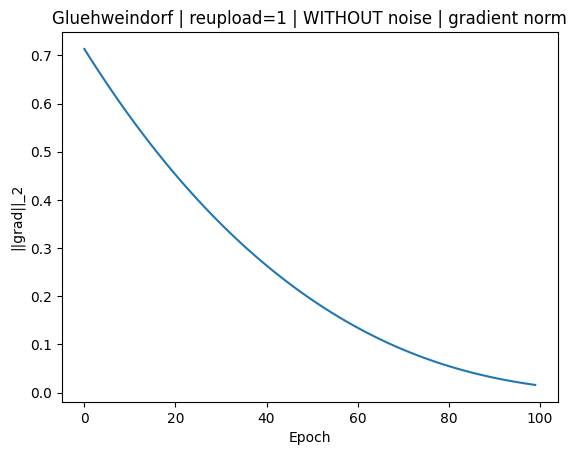

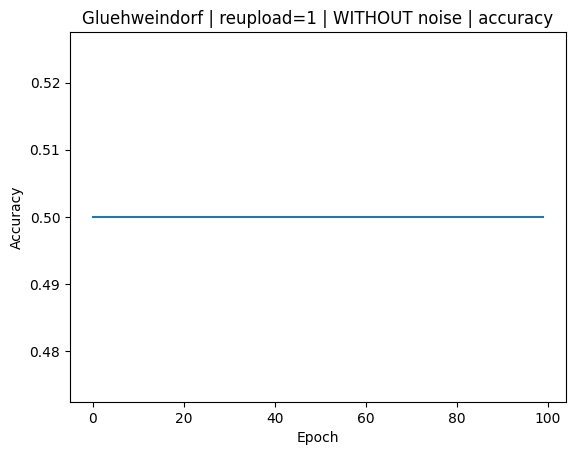


--- WITH noise (type=depolarizing, p=0.02) ---
Epoch   1 | Cost = 2.1395 | Accuracy = 0.500 | GradNorm = 0.9280
Epoch  11 | Cost = 1.9791 | Accuracy = 0.500 | GradNorm = 1.9395
Epoch  21 | Cost = 1.6278 | Accuracy = 0.500 | GradNorm = 1.9007
Epoch  31 | Cost = 1.3458 | Accuracy = 0.500 | GradNorm = 1.4720
Epoch  41 | Cost = 1.1604 | Accuracy = 0.500 | GradNorm = 1.1571
Epoch  51 | Cost = 1.0380 | Accuracy = 0.500 | GradNorm = 0.9429
Epoch  61 | Cost = 0.9535 | Accuracy = 0.500 | GradNorm = 0.7892
Epoch  71 | Cost = 0.8926 | Accuracy = 0.500 | GradNorm = 0.6720
Epoch  81 | Cost = 0.8470 | Accuracy = 0.500 | GradNorm = 0.5783
Epoch  91 | Cost = 0.8121 | Accuracy = 0.500 | GradNorm = 0.5005
Epoch 100 | Cost = 0.7873 | Accuracy = 0.500 | GradNorm = 0.4405

Confusion Matrix (rows=true, cols=pred):
[[250   0]
 [250   0]]


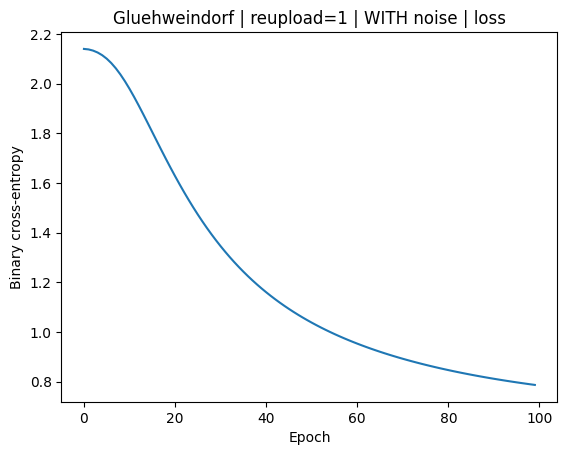

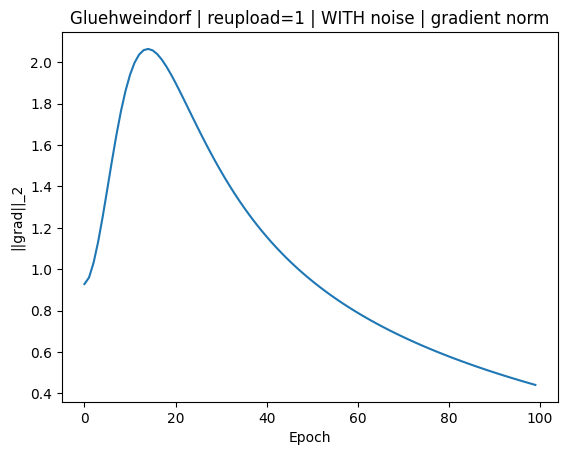

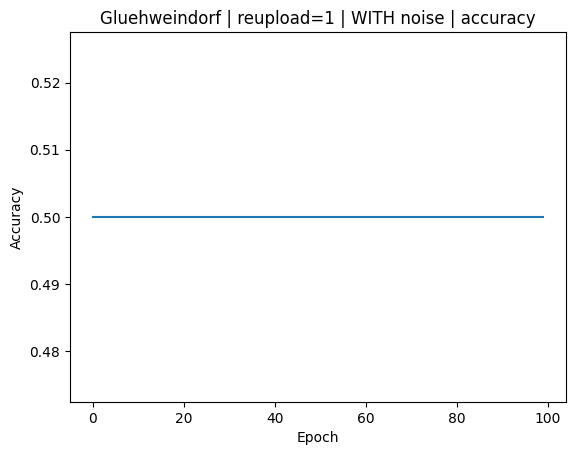


=== Gluehweindorf | Reuploading count: 3 ===

--- WITHOUT noise (type=depolarizing, p=0.02) ---
Epoch   1 | Cost = 1.0802 | Accuracy = 0.500 | GradNorm = 0.6641
Epoch  11 | Cost = 0.9850 | Accuracy = 0.494 | GradNorm = 0.5483
Epoch  21 | Cost = 0.9017 | Accuracy = 0.494 | GradNorm = 0.4397
Epoch  31 | Cost = 0.8424 | Accuracy = 0.504 | GradNorm = 0.3576
Epoch  41 | Cost = 0.8009 | Accuracy = 0.514 | GradNorm = 0.2954
Epoch  51 | Cost = 0.7716 | Accuracy = 0.494 | GradNorm = 0.2466
Epoch  61 | Cost = 0.7505 | Accuracy = 0.500 | GradNorm = 0.2069
Epoch  71 | Cost = 0.7350 | Accuracy = 0.492 | GradNorm = 0.1738
Epoch  81 | Cost = 0.7235 | Accuracy = 0.502 | GradNorm = 0.1456
Epoch  91 | Cost = 0.7150 | Accuracy = 0.494 | GradNorm = 0.1214
Epoch 100 | Cost = 0.7093 | Accuracy = 0.494 | GradNorm = 0.1027

Confusion Matrix (rows=true, cols=pred):
[[114 136]
 [117 133]]


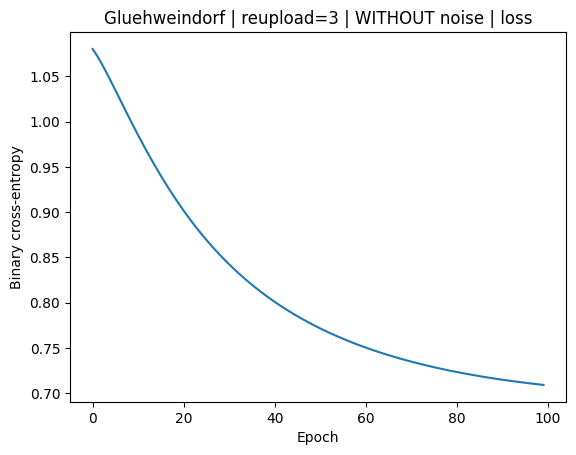

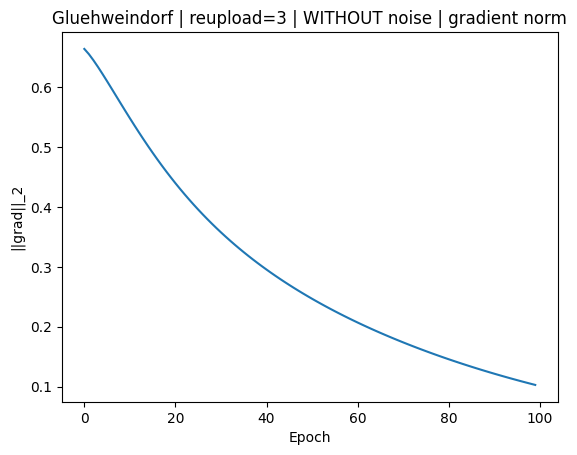

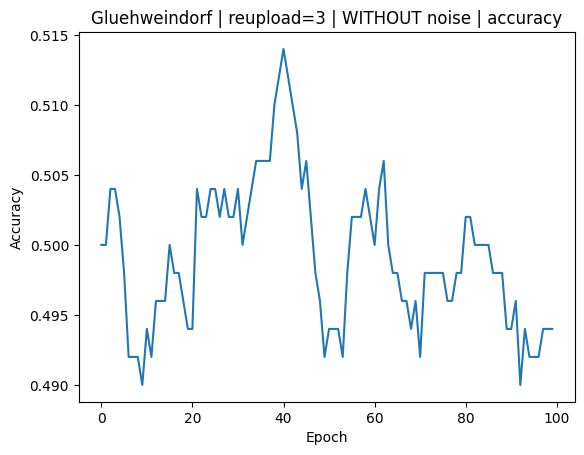


--- WITH noise (type=depolarizing, p=0.02) ---
Epoch   1 | Cost = 0.7482 | Accuracy = 0.502 | GradNorm = 0.2075
Epoch  11 | Cost = 0.7453 | Accuracy = 0.506 | GradNorm = 0.2019
Epoch  21 | Cost = 0.7385 | Accuracy = 0.490 | GradNorm = 0.1882


In [ ]:
# -----------------------------
# Evaluation: Gluehweindorf Task 3 change
# -----------------------------
opt = qml.AdamOptimizer(stepsize=0.01)

num_qubits = 2

# Task 3 change: use mixed-state device for fair comparison (noise requires it)
dev = qml.device("default.mixed", wires=num_qubits)

qml_circuit = make_qml_circuit(dev)

encoding_fn = amplitude_encoding
entanglement_fn = linear_entanglement

X = X_train[gluehwein]
Y = y_train[gluehwein]


for reuploading_count in (1, 3):
    print(f"\n=== Gluehweindorf | Reuploading count: {reuploading_count} ===")

    # Task 3 addition: run both settings (without noise vs with noise)
    for use_noise in (False, True):
        label = "WITH noise" if use_noise else "WITHOUT noise"
        print(f"\n--- {label} (type={NOISE_TYPE}, p={NOISE_P}) ---")

        weights = qnp.array(
            np.random.uniform(0, math.pi, size=(reuploading_count, num_qubits)),
            requires_grad=True
        )

        # Task 3 addition: extend param with use_noise flag
        param = [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise]

        # Task 3 addition: track loss / grad norm / accuracy
        loss_history = []
        gradnorm_history = []
        acc_history = []

        for epoch in range(100):

            # Task 3 addition: compute gradient norm (before update)
            grad = qml.grad(cost)(weights, param)
            grad_norm = float(np.linalg.norm(qml.math.toarray(grad)))

            args, current_cost = opt.step_and_cost(cost, weights, param)
            weights = args[0]

            y_pred = predict(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise=use_noise)
            acc = accuracy(Y, y_pred)

            loss_history.append(float(current_cost))
            gradnorm_history.append(grad_norm)
            acc_history.append(float(acc))

            if epoch % 10 == 0 or epoch == 99:
                print(
                    f"Epoch {epoch + 1:3d} | "
                    f"Cost = {current_cost:.4f} | "
                    f"Accuracy = {acc:.3f} | "
                    f"GradNorm = {grad_norm:.4f}"
                )

            if epoch == 99:
                cm = confusion_matrix(Y, y_pred)
                print("\nConfusion Matrix (rows=true, cols=pred):")
                print(cm)

        # Task 3 addition: plots for this run
        plt.figure()
        plt.plot(loss_history)
        plt.title(f"Gluehweindorf | reupload={reuploading_count} | {label} | loss")
        plt.xlabel("Epoch")
        plt.ylabel("Binary cross-entropy")
        plt.show()

        plt.figure()
        plt.plot(gradnorm_history)
        plt.title(f"Gluehweindorf | reupload={reuploading_count} | {label} | gradient norm")
        plt.xlabel("Epoch")
        plt.ylabel("||grad||_2")
        plt.show()

        plt.figure()
        plt.plot(acc_history)
        plt.title(f"Gluehweindorf | reupload={reuploading_count} | {label} | accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.show()


## Krampus

In [ ]:
# opt = qml.AdamOptimizer(stepsize=0.01)

# num_qubits = 2
# dev = qml.device("default.qubit", wires=num_qubits)
# qml_circuit = make_qml_circuit(dev)

# encoding_fn = angle_encoding
# entanglement_fn = circular_entanglement 

# X = X_train[krampus]
# Y = y_train[krampus]



# for reuploading_count in (1, 3):
#     print(f"\n=== Reuploading count: {reuploading_count} ===")

#     weights = qnp.array(
#         np.random.uniform(0, math.pi, size=(reuploading_count, num_qubits)),
#         requires_grad=True
#     )

#     param = [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count]

#     for epoch in range(100):
#         args, current_cost = opt.step_and_cost(cost, weights, param)
#         weights = args[0]

#         # ---- evaluation (NO gradients needed) ----
#         y_pred = predict(
#             weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count
#         )
#         acc = accuracy(Y, y_pred)

#         if epoch % 10 == 0 or epoch == 99:
#             print(
#                 f"Epoch {epoch + 1:3d} | "
#                 f"Cost = {current_cost:.4f} | "
#                 f"Accuracy = {acc:.3f}"
#             )

#         if epoch == 99:
#             cm = confusion_matrix(Y, y_pred)
#             print("\nConfusion Matrix (rows=true, cols=pred):")
#             print(cm)    


=== Reuploading count: 1 ===


ValueError: not enough values to unpack (expected 7, got 6)

In [ ]:
# -----------------------------
# Evaluation: Krampus Task 3 change
# -----------------------------
opt = qml.AdamOptimizer(stepsize=0.01)

num_qubits = 2

# Task 3 change: use mixed-state device for fair comparison (noise requires it)
dev = qml.device("default.mixed", wires=num_qubits)

qml_circuit = make_qml_circuit(dev)

encoding_fn = angle_encoding
entanglement_fn = circular_entanglement

X = X_train[krampus]
Y = y_train[krampus]


for reuploading_count in (1, 3):
    print(f"\n=== Krampus | Reuploading count: {reuploading_count} ===")

    # Task 3 addition: run both settings (without noise vs with noise)
    for use_noise in (False, True):
        label = "WITH noise" if use_noise else "WITHOUT noise"
        print(f"\n--- {label} (type={NOISE_TYPE}, p={NOISE_P}) ---")

        weights = qnp.array(
            np.random.uniform(0, math.pi, size=(reuploading_count, num_qubits)),
            requires_grad=True
        )

        param = [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise]

        loss_history = []
        gradnorm_history = []
        acc_history = []

        for epoch in range(100):

            grad = qml.grad(cost)(weights, param)
            grad_norm = float(np.linalg.norm(qml.math.toarray(grad)))

            args, current_cost = opt.step_and_cost(cost, weights, param)
            weights = args[0]

            y_pred = predict(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise=use_noise)
            acc = accuracy(Y, y_pred)

            loss_history.append(float(current_cost))
            gradnorm_history.append(grad_norm)
            acc_history.append(float(acc))

            if epoch % 10 == 0 or epoch == 99:
                print(
                    f"Epoch {epoch + 1:3d} | "
                    f"Cost = {current_cost:.4f} | "
                    f"Accuracy = {acc:.3f} | "
                    f"GradNorm = {grad_norm:.4f}"
                )

            if epoch == 99:
                cm = confusion_matrix(Y, y_pred)
                print("\nConfusion Matrix (rows=true, cols=pred):")
                print(cm)

        plt.figure()
        plt.plot(loss_history)
        plt.title(f"Krampus | reupload={reuploading_count} | {label} | loss")
        plt.xlabel("Epoch")
        plt.ylabel("Binary cross-entropy")
        plt.show()

        plt.figure()
        plt.plot(gradnorm_history)
        plt.title(f"Krampus | reupload={reuploading_count} | {label} | gradient norm")
        plt.xlabel("Epoch")
        plt.ylabel("||grad||_2")
        plt.show()

        plt.figure()
        plt.plot(acc_history)
        plt.title(f"Krampus | reupload={reuploading_count} | {label} | accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.show()


## Lebkuchen

In [ ]:
# opt = qml.AdamOptimizer(stepsize=0.01)

# num_qubits = 1
# dev = qml.device("default.mixed", wires=num_qubits)
# qml_circuit = make_qml_circuit(dev)

# encoding_fn = density_matrix_encoding
# entanglement_fn = full_entanglement 

# X = X_train[lebkuchen]
# Y = y_train[lebkuchen]


# for reuploading_count in (1, 3):
#     weights = qnp.array(
#         np.random.uniform(0, math.pi, size=(reuploading_count, num_qubits)), 
#         requires_grad=True
#     )
    
#     param = [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count]

#     for epoch in range(100):
#         args, current_cost = opt.step_and_cost(cost, weights, param)
#         weights = args[0]
#         if epoch % 10 == 0 or epoch == 99: 
#             print(f"Epoch {epoch + 1}: Cost = {current_cost:.4f} Weights = {weights}")
    

Epoch 1: Cost = 1.2117 Weights = [[1.46325162]]
Epoch 11: Cost = 1.2081 Weights = [[1.46139378]]
Epoch 21: Cost = 1.2082 Weights = [[1.46012994]]
Epoch 31: Cost = 1.2081 Weights = [[1.46010363]]
Epoch 41: Cost = 1.2081 Weights = [[1.46040019]]
Epoch 51: Cost = 1.2080 Weights = [[1.46041285]]
Epoch 61: Cost = 1.2080 Weights = [[1.46017626]]
Epoch 71: Cost = 1.2080 Weights = [[1.46025275]]
Epoch 81: Cost = 1.2080 Weights = [[1.46029608]]
Epoch 91: Cost = 1.2080 Weights = [[1.46029657]]
Epoch 100: Cost = 1.2080 Weights = [[1.4603127]]
Epoch 1: Cost = 1.6090 Weights = [[0.24686091]
 [2.39591723]
 [0.92127121]]
Epoch 11: Cost = 1.2335 Weights = [[0.33117002]
 [2.48022634]
 [1.00558032]]
Epoch 21: Cost = 1.0651 Weights = [[0.41327445]
 [2.56233077]
 [1.08768475]]
Epoch 31: Cost = 0.9592 Weights = [[0.467422  ]
 [2.61647833]
 [1.1418323 ]]
Epoch 41: Cost = 0.8946 Weights = [[0.52596577]
 [2.67502209]
 [1.20037607]]
Epoch 51: Cost = 0.9006 Weights = [[0.53253494]
 [2.68159126]
 [1.20694524]]
E

In [ ]:
# -----------------------------
# Evaluation: Lebkuchen Task 3 change
# -----------------------------
opt = qml.AdamOptimizer(stepsize=0.01)

num_qubits = 1

# Already mixed-state (good for noise + fair comparison)
dev = qml.device("default.mixed", wires=num_qubits)

qml_circuit = make_qml_circuit(dev)

encoding_fn = density_matrix_encoding
entanglement_fn = full_entanglement

X = X_train[lebkuchen]
Y = y_train[lebkuchen]


for reuploading_count in (1, 3):
    print(f"\n=== Lebkuchen | Reuploading count: {reuploading_count} ===")

    # Task 3 addition: run both settings (without noise vs with noise)
    for use_noise in (False, True):
        label = "WITH noise" if use_noise else "WITHOUT noise"
        print(f"\n--- {label} (type={NOISE_TYPE}, p={NOISE_P}) ---")

        weights = qnp.array(
            np.random.uniform(0, math.pi, size=(reuploading_count, num_qubits)),
            requires_grad=True
        )

        param = [X, Y, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise]

        loss_history = []
        gradnorm_history = []
        acc_history = []

        for epoch in range(100):

            grad = qml.grad(cost)(weights, param)
            grad_norm = float(np.linalg.norm(qml.math.toarray(grad)))

            args, current_cost = opt.step_and_cost(cost, weights, param)
            weights = args[0]

            # Task 3 addition: compute accuracy also for Lebkuchen
            y_pred = predict(weights, X, qml_circuit, encoding_fn, entanglement_fn, reuploading_count, use_noise=use_noise)
            acc = accuracy(Y, y_pred)

            loss_history.append(float(current_cost))
            gradnorm_history.append(grad_norm)
            acc_history.append(float(acc))

            if epoch % 10 == 0 or epoch == 99:
                print(
                    f"Epoch {epoch + 1:3d} | "
                    f"Cost = {current_cost:.4f} | "
                    f"Accuracy = {acc:.3f} | "
                    f"GradNorm = {grad_norm:.4f}"
                )

            if epoch == 99:
                cm = confusion_matrix(Y, y_pred)
                print("\nConfusion Matrix (rows=true, cols=pred):")
                print(cm)

        plt.figure()
        plt.plot(loss_history)
        plt.title(f"Lebkuchen | reupload={reuploading_count} | {label} | loss")
        plt.xlabel("Epoch")
        plt.ylabel("Binary cross-entropy")
        plt.show()

        plt.figure()
        plt.plot(gradnorm_history)
        plt.title(f"Lebkuchen | reupload={reuploading_count} | {label} | gradient norm")
        plt.xlabel("Epoch")
        plt.ylabel("||grad||_2")
        plt.show()

        plt.figure()
        plt.plot(acc_history)
        plt.title(f"Lebkuchen | reupload={reuploading_count} | {label} | accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.show()


In [25]:
def make_qml_circuit_2(dev):
    @qml.qnode(dev)
    def qml_circuit(weights, inputs, reuploading_count):
        # We repeat the (Encoding -> Entanglement -> Trainable) block
        for j in range(reuploading_count):
            
            # 1. Angle Encoding (Re-uploading)
            # We use RX to encode the first feature and RY for the second
            for i in range(num_qubits):
                qml.RX(inputs[0], wires=i)
                qml.RY(inputs[1], wires=i)
            
            # 2. Entanglement
            if num_qubits > 1:
                for i in range(num_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
            
            # 3. Trainable Layer (General Rotation)
            for i in range(num_qubits):
                # Using Rot (phi, theta, omega) for full Bloch sphere coverage
                qml.Rot(weights[j, i, 0], weights[j, i, 1], weights[j, i, 2], wires=i)

        return qml.expval(qml.PauliZ(0))
    
    return qml_circuit

In [27]:
# --- Setup ---
num_qubits = 2
reuploading_count = 3  # More layers = more complex decision boundaries
dev = qml.device("default.qubit", wires=num_qubits)
qml_circuit = make_qml_circuit_2(dev)

# --- Data ---
X = qnp.array(X_train[gluehwein], requires_grad=False)
Y = qnp.array(y_train[gluehwein], requires_grad=False)

# --- Initialization ---
# 3 weights per qubit per layer for qml.Rot
weights = qnp.array(
    np.random.uniform(0, 2 * np.pi, size=(reuploading_count, num_qubits, 3)),
    requires_grad=True
)

opt = qml.AdamOptimizer(stepsize=0.1) # Increased stepsize for faster convergence

# --- Training Loop ---
for epoch in range(100):
    # The cost function needs to be updated to match the new circuit signature
    def cost_fn(w):
        # Map expval [-1, 1] to [eps, 1-eps] for BCE loss
        predictions = qnp.array([
            (qml_circuit(w, x, reuploading_count) * 0.499 + 0.5)
            for x in X
        ])
        return -qnp.mean(Y * qnp.log(predictions) + (1 - Y) * qnp.log(1 - predictions))

    weights, current_cost = opt.step_and_cost(cost_fn, weights)

    if (epoch + 1) % 10 == 0:
        # Quick accuracy check
        y_pred = qnp.array([qml_circuit(weights, x, reuploading_count) for x in X]) > 0
        acc = qnp.mean(y_pred == Y)
        print(f"Epoch {epoch+1:3d} | Cost: {current_cost:.4f} | Acc: {acc:.3f}")

Epoch  10 | Cost: 0.4249 | Acc: 0.876
Epoch  20 | Cost: 0.3758 | Acc: 0.874
Epoch  30 | Cost: 0.2683 | Acc: 0.946
Epoch  40 | Cost: 0.2412 | Acc: 0.966
Epoch  50 | Cost: 0.2343 | Acc: 0.976
Epoch  60 | Cost: 0.2299 | Acc: 0.974
Epoch  70 | Cost: 0.2285 | Acc: 0.972
Epoch  80 | Cost: 0.2284 | Acc: 0.972
Epoch  90 | Cost: 0.2281 | Acc: 0.972
Epoch 100 | Cost: 0.2281 | Acc: 0.974
